# PyTorch Workflow

### Resource Link : https://www.learnpytorch.io/01_pytorch_workflow/

In [1]:
import torch
from torch import nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Data Preparation And Loading

In [3]:
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim = 1)
y = weight*X + bias

X = X.to(device)
y = y.to(device)

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]], device='cuda:0'),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]], device='cuda:0'))

In [4]:
len(X), len(y)

(50, 50)

In [5]:
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(X_test)

(40, 10)

In [6]:
def plot_predictions(train_data = X_train, train_labels = y_train, test_data = X_test, test_labels = y_test, predictions = None):
    plt.figure(figsize = (10,7))
    plt.scatter(train_data.cpu().numpy(), train_labels.cpu().numpy(), c="b", s=4, label="Training Data")
    plt.scatter(test_data.cpu().numpy(), test_labels.cpu().numpy(), c="g", s=4, label="Testing Data")
    if predictions is not None:
        plt.scatter(test_data.cpu().numpy(), predictions.cpu().numpy(), c="r", s=4, label="Predictions")
    plt.legend(prop={"size":14})

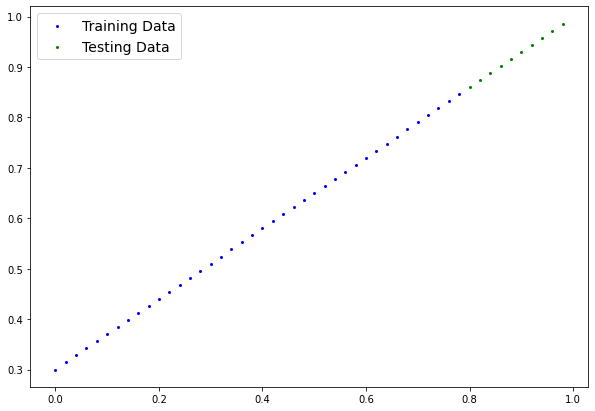

In [7]:
plot_predictions()

## Build Model

<ol>
    <li>Start with random values</li>
    <li>Look at training data</li>
    <li>Adjust random values to get close to ideal values using Gradient Descent and Backpropogation</li>
</ol>

In [141]:
class LinearRegressionModel(nn.Module): # Inherits from nn.module. Contains all the building blocks for neural networks 
    def __init__(self):
        super().__init__()
        #Initialize model parameters
        self.weights = nn.Parameter(torch.rand(1, requires_grad = True, dtype = torch.float))
        #requires grad = True will track the gradients of this specific parameter for use with torch.autograd and grad descent
        self.bias = nn.Parameter(torch.rand(1, requires_grad = True, dtype = torch.float))
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        #Defines computation in the model
        #Any subclass of nn.module needs to override forward()
        #x is the input data
        return self.weights * x + self.bias
        
    

PyTorch Model Building essentials
<ol>
    <li>torch.nn - contains all the building blocks for the Neural Network</li>
    <li>torch.nn.Parameter - what params should our model try and learn</li>
    <li>torch.nn.Module - Base class for all Neural Net modules</li>
    <li>torch.optim - Optimizers that help with gradient descent</li>
    <li>def forward() - Required to override</li>
</ol>
To get data ready some important modules are - 
<ol>
    <li>torchvision.transforms</li>
    <li>torch.utils.data.Dataset</li>
    <li>torch.utils.data.DataLoader</li>
</ol>

In [142]:
torch.manual_seed(5)

model_0 = LinearRegressionModel()

model_0

LinearRegressionModel()

In [143]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.8303], requires_grad=True),
 Parameter containing:
 tensor([0.1261], requires_grad=True)]

In [144]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.8303])), ('bias', tensor([0.1261]))])

### When we pass data through our model, its going to run it through forward()

In [145]:
with torch.inference_mode():
    y_preds = model_0(X_test)
    
y_preds, y_test

(tensor([[0.7903],
         [0.8069],
         [0.8235],
         [0.8401],
         [0.8567],
         [0.8733],
         [0.8899],
         [0.9065],
         [0.9232],
         [0.9398]]),
 tensor([[0.8600],
         [0.8740],
         [0.8880],
         [0.9020],
         [0.9160],
         [0.9300],
         [0.9440],
         [0.9580],
         [0.9720],
         [0.9860]]))

When we are doing inference, we don't need to keep tracks of gradients as we are not doing training

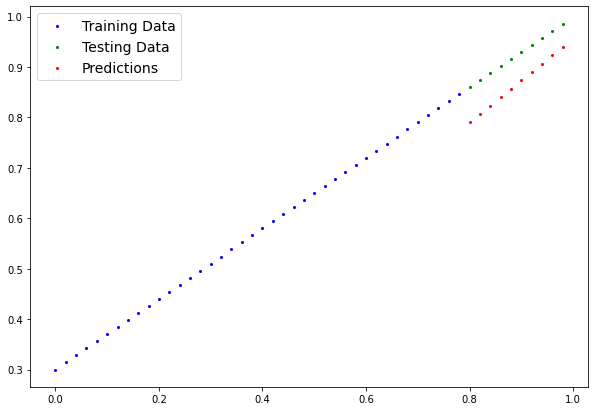

In [146]:
plot_predictions(predictions = y_preds)

In [147]:
with torch.no_grad():
    y_preds = model_0(X_test)
    
y_preds, y_test

(tensor([[0.7903],
         [0.8069],
         [0.8235],
         [0.8401],
         [0.8567],
         [0.8733],
         [0.8899],
         [0.9065],
         [0.9232],
         [0.9398]]),
 tensor([[0.8600],
         [0.8740],
         [0.8880],
         [0.9020],
         [0.9160],
         [0.9300],
         [0.9440],
         [0.9580],
         [0.9720],
         [0.9860]]))

## Model Training

A way to measure how poor the model's predictions are is to use a loss function. Loss function may also be called a cost function or criterion in different areas.<br>
Optimizer takes into account the loss of a model and adjusts the models parameters (weight and bias) to improve the loss function.<br>
For PyTorch we need a train loop and a test loop

### Setting up Loss Function

In [148]:
loss_fn = nn.L1Loss()

### Setting up an Optimizer

In [149]:
# Stochastic Gradient Descent
# Learning rate defines how big/small the optimizer changes the parameters with each step
optimizer = torch.optim.SGD(model_0.parameters(), lr=0.01)

### Build Training loop
0. Loop through the data and do..
1. Forward pass to make predictions on data (Data passes through the models forward function)
2. Calculate the loss
3. Optimizer zero grad
4. Loss Backward - move backwards thru NN to calculate the gradients of each of the params of our model wrt the loss [backprop]
5. Optimizer step - use optimizer to adjust our models params to try and improve the loss [gradient descent]

In [150]:
torch.manual_seed(5)

epoch_count = []
loss_values = []
test_loss_values = []

epochs = 201 #Another hyperparameter

# Step 0
for epoch in range(epochs):
    # Set the model to training mode
    model_0.train() #Sets all params that require gradients to require gradients
    
    #Step 1
    y_pred = model_0(X_train)
    
    #Step 2
    loss = loss_fn(y_pred, y_train) # predictions then actual is official format
    
    #Step 3
    optimizer.zero_grad() #Prevents accumulation of the optimizer value
    
    #Step 4
    loss.backward() #calculate gradients of each parameter which has grad=True
    
    #Step 5
    optimizer.step() #Perform gradient descent to update the model parameters
    
    model_0.eval() #Turns off different settings in the model not needed for testing (droput/batchnorm)

    with torch.inference_mode(): # Turns off gradient tracking & other things in background. Faster performance. Not necessary.
        #Step 1 Testing
        test_pred = model_0(X_test)
        #Step 2 Testing
        test_loss = loss_fn(test_pred, y_test)
        
    if epoch%10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss} | Test Loss: {test_loss}")
        print(model_0.state_dict())
        
    epoch_count.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)

Epoch: 0 | Loss: 0.12309086322784424 | Test Loss: 0.044493936002254486
OrderedDict([('weights', tensor([0.8342])), ('bias', tensor([0.1361]))])
Epoch: 10 | Loss: 0.036871932446956635 | Test Loss: 0.05862991139292717
OrderedDict([('weights', tensor([0.8596])), ('bias', tensor([0.2166]))])
Epoch: 20 | Loss: 0.030283555388450623 | Test Loss: 0.06788599491119385
OrderedDict([('weights', tensor([0.8481])), ('bias', tensor([0.2361]))])
Epoch: 30 | Loss: 0.02679416537284851 | Test Loss: 0.06167420744895935
OrderedDict([('weights', tensor([0.8315])), ('bias', tensor([0.2446]))])
Epoch: 40 | Loss: 0.02336020953953266 | Test Loss: 0.054088614881038666
OrderedDict([('weights', tensor([0.8146])), ('bias', tensor([0.2521]))])
Epoch: 50 | Loss: 0.01992935687303543 | Test Loss: 0.04581606388092041
OrderedDict([('weights', tensor([0.7974])), ('bias', tensor([0.2591]))])
Epoch: 60 | Loss: 0.016490545123815536 | Test Loss: 0.03754352405667305
OrderedDict([('weights', tensor([0.7803])), ('bias', tensor([

In [151]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.7061])), ('bias', tensor([0.3016]))])

In [137]:
with torch.inference_mode():
    y_preds_new = model_0(X_test)

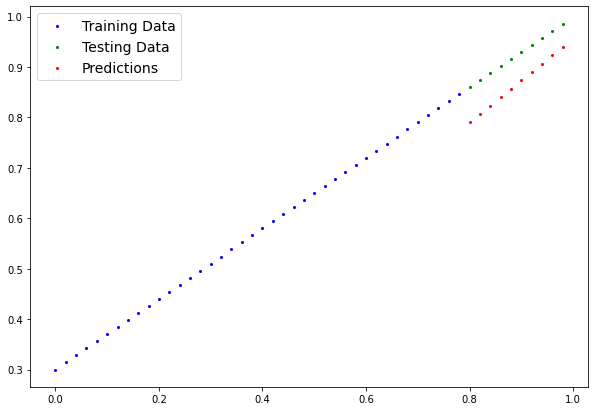

In [138]:
plot_predictions(predictions = y_preds)

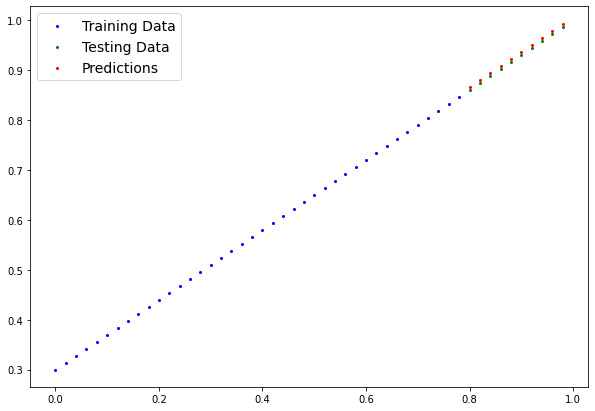

In [139]:
plot_predictions(predictions = y_preds_new)

### Building Testing Loop

In [125]:
model_0.eval() #Turns off different settings in the model not needed for testing (droput/batchnorm)

with torch.inference_mode(): # Turns off gradient tracking & other things in background
    #Step 1
    test_pred = model_0(X_test)
    #Step 2
    test_loss = loss_fn(test_pred, y_test)
    print(test_loss)

tensor(0.0075)


## Model Evaluation

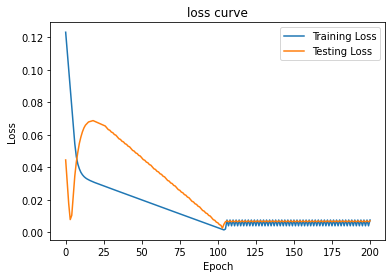

In [153]:
plt.plot(epoch_count, np.array(torch.tensor(loss_values).cpu().numpy()), label = "Training Loss")
plt.plot(epoch_count, np.array(torch.tensor(test_loss_values).cpu().numpy()), label = "Testing Loss")
plt.title("loss curve")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()

## Saving And Loading Model

Three main methods to save and load models
1. torch.save - allows saving in Python pkl format
2. torch.load - allows loading a saved pytroch object
3. torch.nn.Module.load_state_dict() - this allows you to load a model's saved state dict

In [157]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents = True, exist_ok = True)

MODEL_NAME = "01_Linear_Regression_Model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

torch.save(obj = model_0.state_dict(), f = MODEL_SAVE_PATH)

Create a new instance of model class and load the saved state_dict) into that

In [158]:
loaded_model_0 = LinearRegressionModel()

loaded_model_0.load_state_dict(torch.load(f = MODEL_SAVE_PATH))

<All keys matched successfully>

In [159]:
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.7061])), ('bias', tensor([0.3016]))])

In [160]:
loaded_model_0.eval()
with torch.inference_mode():
    loaded_model_preds = loaded_model_0(X_test)
    
loaded_model_preds

tensor([[0.8665],
        [0.8806],
        [0.8947],
        [0.9088],
        [0.9229],
        [0.9371],
        [0.9512],
        [0.9653],
        [0.9794],
        [0.9936]])

In [161]:
y_preds_new == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

## Linear Model V2

In [10]:
class LinearRegressionModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        #Use nn.Linear() for creating the model params
        # linear transform, probing layer, fully connected layer, dense layer
        self.linear_layer = nn.Linear(in_features = 1,
                                      out_features = 1) #One value of x maps to one value of y
        #implements linear regression formula
        #behind the scenes creates weight and bias params
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)
    
torch.manual_seed(5)
model = LinearRegressionModelV2()
model.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6605]])),
             ('linear_layer.bias', tensor([-0.7478]))])

In [11]:
next(model.parameters()).device

device(type='cpu')

In [12]:
model.to(device)
next(model.parameters()).device

device(type='cuda', index=0)

In [13]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params = model.parameters(),
                            lr = 0.01)

In [14]:
torch.manual_seed(5)

epoch_count = []
loss_values = []
test_loss_values = []

epochs = 201

for epoch in range(epochs):
    model.train()
    y_pred = model(X_train)
    loss = loss_fn(y_pred, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    model.eval()
    with torch.inference_mode():
        test_pred = model(X_test)
        test_loss = loss_fn(test_pred, y_test)
        
    if epoch%10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss} | Test Loss: {test_loss}")
        print(model.state_dict())
        
    epoch_count.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)

Epoch: 0 | Loss: 1.063181757926941 | Test Loss: 1.0694589614868164
OrderedDict([('linear_layer.weight', tensor([[0.6644]], device='cuda:0')), ('linear_layer.bias', tensor([-0.7378], device='cuda:0'))])
Epoch: 10 | Loss: 0.9479719400405884 | Test Loss: 0.9347490668296814
OrderedDict([('linear_layer.weight', tensor([[0.7034]], device='cuda:0')), ('linear_layer.bias', tensor([-0.6378], device='cuda:0'))])
Epoch: 20 | Loss: 0.8327619433403015 | Test Loss: 0.8000392317771912
OrderedDict([('linear_layer.weight', tensor([[0.7424]], device='cuda:0')), ('linear_layer.bias', tensor([-0.5378], device='cuda:0'))])
Epoch: 30 | Loss: 0.717552125453949 | Test Loss: 0.6653293967247009
OrderedDict([('linear_layer.weight', tensor([[0.7814]], device='cuda:0')), ('linear_layer.bias', tensor([-0.4378], device='cuda:0'))])
Epoch: 40 | Loss: 0.6023422479629517 | Test Loss: 0.5306195616722107
OrderedDict([('linear_layer.weight', tensor([[0.8204]], device='cuda:0')), ('linear_layer.bias', tensor([-0.3378], dev

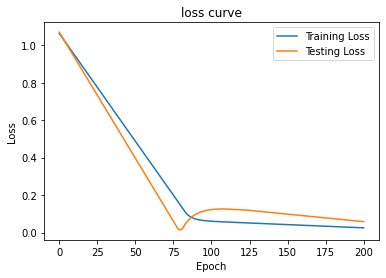

In [15]:
plt.plot(epoch_count, np.array(torch.tensor(loss_values).cpu().numpy()), label = "Training Loss")
plt.plot(epoch_count, np.array(torch.tensor(test_loss_values).cpu().numpy()), label = "Testing Loss")
plt.title("loss curve")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()

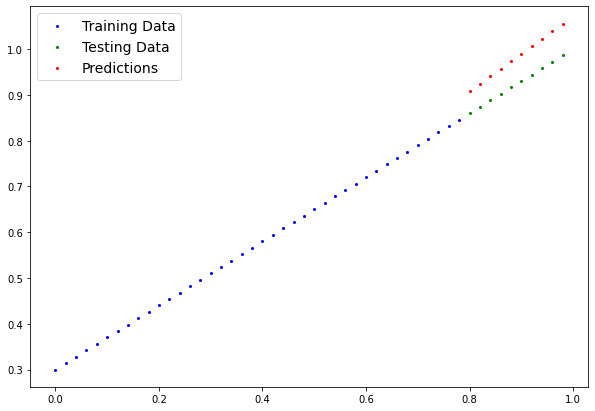

In [16]:
with torch.inference_mode():
    y_preds_new = model(X_test)
    
plot_predictions(predictions = y_preds_new)

In [17]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents = True, exist_ok = True)

MODEL_NAME = "01_Linear_Regression_Model_V2.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

torch.save(obj = model.state_dict(), f = MODEL_SAVE_PATH)

Loading this model will require putting it onto the device